# [Жёлтое такси в Нью-Йорке](https://www.coursera.org/learn/data-analysis-project/supplement/NuH2K/zhioltoie-taksi-v-n-iu-iorkie)

Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти боро города.

Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая информация о поездках:
* VendorID провайдер данных (одна из двух категорий)
* tpep_pickup_datetime - время начала поездки
* tpep_dropoff_datetime - время окончания поездки
* passenger_count - количество пассажиров
* trip_distance - расстояние по счётчику
* pickup_longitude &	pickup_latitude - долгота и широта точки начала поездки
* dropoff_longitude	& dropoff_latitude - долгота и широта точки окончания поездки
* RatecodeID - тип тарифа (одна из шести категорий)
* store_and_fwd_flag	- бинарный флаг, показывающий, были ли данные о поездке получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля
* payment_type - способ оплаты (одна из шести категорий)
* fare_amount - стоимость поездки по счётчику
* extra - доплата за поездки в пиковые часы и ночью
* mta_tax - налог на счётчик
* tip_amount - размер чаевых
* tolls_amount - доплата за проезд по платным дорогам
* improvement_surcharge	- доплата за проезд, взимаемая с каждой поездки с января 2015
* total_amount - общая стоимость поездки

Подробнее: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Задача проекта — научиться предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка; для простоты мы определим прямоугольные районы. Для того, чтобы её решить, сырые данные необходимо агрегировать по часам и районам. Агрегированные данные будут представлять собой почасовые временные ряды с количествами поездок из каждого района.

Задачу прогнозирования таких рядов можно решать с помощью авторегрессионных моделей, прогнозируя каждый ряд независимо. Ряды явно имеют сложную сезонность — суточную, недельную и годовую, поэтому для их моделирования понадобится использовать модель ARIMA с дополнительной регрессией на внешние признаки.

Чтобы улучшить такую модель, можно попытаться учесть:

* взаимосвязи между рядами
* дополнительные параметры поездок, которые можно посчитать по исходным данным
* внешние календарные и географические признаки

В ходе выполнения проекта вы научитесь:

* работать с геоданными
* прогнозировать временные ряды сложной структуры
* строить и настраивать регрессионные модели, делающие совместные предсказания для большого количества взаимосвязанных рядов

Похожие задачи возникают на практике, если вам необходимо спрогнозировать продажи большого количества товаров в большом количестве магазинов, объём снятия денег в сети банкоматов, посещаемость разных страниц сайта и т.д.

В ходе выполнения проекта у вас будет свобода выбора хода решения, используемых средств анализа, библиотек и моделей. Также обратите внимание, что для его успешного выполнения вам нужно будет скачать и обработать от 10 до 200 гигабайт сырых данных.

In [1]:
%pylab inline

from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product

import holidays

Populating the interactive namespace from numpy and matplotlib


---

# [Week 6 - Дополнительные признаки](https://www.coursera.org/learn/data-analysis-project/peer/gtNEG/dopolnitiel-nyie-priznaki)

На этой неделе вам предстоит попробовать добавить в вашу регрессионную модель дополнительные признаки.

Во-первых, для прогнозирования можно использовать информацию, содержащуюся в сырых данных:
* средняя длительность поездок
* среднее количество пассажиров
* среднее расстояние по счётчику
* доли географических зон, в которые совершаются поездки
* доли поездок, совершаемых по тарифам каждого из типов
* доли способов оплаты поездок
* средняя стоимость поездок
* доли провайдеров данных

Все эти признаки можно использовать только с задержкой, то есть, при прогнозировании эти признаки должны быть рассчитаны по данным не позднее момента времени T. Каждый из этих признаков можно использовать по-разному: как сырые значения за последние несколько часов, так и средние за последний день, неделю, месяц и т. д.

Во-вторых, чтобы улучшить качество прогнозов в аномальные периоды, вы можете найти информацию о потенциально влияющих на количество поездок событиях, таких, как государственные праздники. Проанализируйте, как именно поведение пассажиров меняется во время этих событий, и создайте признаки, отражающие эти изменения. Как показывает наш опыт, правильный учёт праздничных дней часто позволяет существенно уменьшить среднюю ошибку прогноза.

В-третьих, можно использовать признаки, связанные с географией. Например, скорее всего, суммарное количество поездок, совершаемых из географической зоны, пропорционально площади этой зоны. Для зон, прилегающих к аэропорту, может быть характерен специфический паттерн дневной сезонности, связанный с тем, что спрос на такси будет повышаться в те часы, когда общественный транспорт перестаёт работать. В деловом центре максимальное количество поездок будет приходиться на начало и окончание рабочего дня, на Бродвее — на время начала и окончания спектаклей. Все эти идеи не обязательно верны, мы приводим их здесь только для того, чтобы продемонстрировать принцип рассуждений. Ещё один пример географического признака: можно попробовать добавить идентификатор боро, который можно найти в файле https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv. Кроме того, нам кажется перспективным использование в качестве фактора количества поездок, совершённых за прошлый час/день и т. д. из соседних географических зон, или количества поездок, совершённых за прошлый час/день в текущую географическую зону.

Много примеров других признаков, которые можно использовать при регрессионном прогнозировании, можно найти в [лекции](https://habr.com/ru/company/yandex/blog/316232/) Вадима Стрижова.

Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Q_may — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

###### Загружаем данные с прошлой недели

In [2]:
week5_X = pd.read_csv('data/df_regions/week5_X.csv', index_col=[0],  header=[0,1,2])

week5_may = pd.read_csv('data/df_regions/week5_may.csv', index_col=[0],  header=[0,1,2])
week5_may.index = pd.to_datetime(week5_may.index, format='%Y-%m-%d %H:%M:%S')

week5_june = pd.read_csv('data/df_regions/week5_june.csv', index_col=[0],  header=[0,1,2])
week5_june.index = pd.to_datetime(week5_june.index, format='%Y-%m-%d %H:%M:%S')

###### Использовались следующие признаки:
* календарные - год, месяц, день недели, час;
* синусы и косинусы по периодами годовой и недельной сезонности;
* количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}...y_{T-K}$;
* количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}...y_{T-24*K_d}$;    
* суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю.

###### Расчитывает ошибку качества прогнозов моделей

In [3]:
def error(df):
    df_error = df.xs('error', level='y', axis=1)
    regions = np.unique((df.columns.get_level_values(level='region'))).shape[0]
    delta = np.unique((df.columns.get_level_values(level='delta'))).shape[0]
    return df_error.sum().sum() / (regions * df_error.shape[0] * delta)

In [4]:
%%time
print('Ошибка качества прогнозов моделей за май составляет ', error(week5_may))

Ошибка качества прогнозов моделей за май составляет  22.827361210609638
Wall time: 31 ms


In [5]:
%%time
print('Ошибка качества прогнозов моделей за июнь составляет ', error(week5_june))

Ошибка качества прогнозов моделей за июнь составляет  20.99610128433658
Wall time: 36 ms


###### Оптимизация параметров

In [30]:
def features_predict(df, param):
    df_regions = pd.DataFrame(index=df.index)
    N = param[0]
    K = param[1]
    Kd = param[2]
    
    ## Признаки общие для всех регионов
    # календарные признаки
    df_regions[('for_all', 'X', 'year')] = df.index.year
    df_regions[('for_all', 'X', 'month')] = df.index.month
    df_regions[('for_all', 'X', 'day')] = df.index.day
    df_regions[('for_all', 'X', 'weekday')] = df.index.weekday
    df_regions[('for_all', 'X', 'hour')] = df.index.hour
    
    row = np.arange(1, df.shape[0]+1)
    for i in range(1, N+1):
        # годовая сезонность
        df_regions[('for_all', 'X', 'y_c_'+str(i))] = np.cos(row*2*np.pi*i/8766)
        df_regions[('for_all', 'X', 'y_s_'+str(i))] = np.sin(row*2*np.pi*i/8766)
        # недельная сезонность
        df_regions[('for_all', 'X', 'w_c_'+str(i))] = np.cos(row*2*np.pi*i/168)
        df_regions[('for_all', 'X', 'w_s_'+str(i))] = np.sin(row*2*np.pi*i/168)
        # дневная сезонность
        df_regions[('for_all', 'X', 'd_c_'+str(i))] = np.cos(row*2*np.pi*i/24)
        df_regions[('for_all', 'X', 'd_s_'+str(i))] = np.sin(row*2*np.pi*i/24)

    ## Признаки индивидуальные для каждого региона
    for region in df.columns:
        
        # кол-во поездок в момент времени (y.T-K)
        for k in range(1, K+1):
            df_regions[(region, 'X', 'T-'+str(k))] = df[region].shift(k)
        
        # кол-во поездок в момент времени (y.T-24*Kd)
        for kd in range(1, Kd+1):
            df_regions[(region, 'X', 'T-24*'+str(kd))] = df[region].shift(24*kd)
        
        # суммарное количество поездок за предшествующие полдня, сутки, неделю
        sum_N = [12, 24, 168]
        for sum_n in sum_N:
            df_regions[(region, 'X', 'sum_'+str(sum_n))] = df[region].rolling(min_periods=1, window=sum_n).sum().shift(1)
    
        ## Добавляем кол-во поездок по регионам
        df_regions[(region, 'y', 'real')] = df[region]
        for t in range(1,7):
            df_regions[(region, 'y', str(t))] = df[region].shift(-t)
    
    df_regions.columns = pd.MultiIndex.from_tuples(df_regions.columns, names=['region', 'X and y', 'features'])
    df = df_regions[['for_all','1231']][168:]
    
    regions = np.unique((df.columns.get_level_values(level='region')))[:-1]
    len_region = regions.shape[0]
    
    start_may = '2016-04-30 23:00:00'
    end_may = '2016-05-31 17:00:00'
    predict_may = pd.DataFrame(index=df[start_may:end_may].index)

    start_june = '2016-05-31 23:00:00'
    end_june = '2016-06-30 17:00:00'
    predict_june = pd.DataFrame(index=df[start_june:end_june].index)
    
    for region in regions:
        print('Расчет предсказания для региона - {}, осталось обработать регионов - {}'.format(region, len_region-1))
        len_region -= 1
        
        X = pd.merge(df[('for_all','X')], df[(region, 'X')], left_index=True, right_index=True)
        
        mse_error = []
        for t in range(1, 7):
            print('Расчет предсказания на {} ч вперед'.format(t))
            y = df[(region, 'y', str(t))]
            ## ПРЕДСКАЗАНИЕ НА МАЙ 2016
            # разделяем данные на обучение, тестовые и итоговые
            X_train, y_train = X[:predict_may.index[0] - timedelta(hours=1)], y[:predict_may.index[0] - timedelta(hours=1)]
            X_test_may = X[start_may:end_may]
            predict_may[(region, 'y', str(t))] = df[(region, 'y', str(t))][start_may:end_may]

            # построение модели с подбором гиперпараметров
            model = Ridge()
            param_grid = [{'alpha' : np.logspace(2, 3, 50)}]
            clf = GridSearchCV(model, param_grid, cv = 5)
            best_model = clf.fit(X_train, y_train)

            # сохраняем предсказания
            predict_may[(region, 'y_predict', str(t))] = best_model.predict(X_test_may).round()   
            predict_may[(region, 'error', str(t))] = (predict_may[(region, 'y_predict', str(t))] - predict_may[(region, 'y', str(t))]).abs()

            mse_error.append(mean_squared_error(predict_may[(region, 'y_predict', str(t))], predict_may[(region, 'y', str(t))]))
        print(mse_error)
    return mse_error

In [43]:
N = range(15, 50)
K = range(6, 25)
Kd = range(2, 8)
parameters = product(N, K, Kd)
mse_errors = []
for params in list(parameters):
    mse_errors.append(features_predict(df, params))

Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9405.370771312584, 12613.577807848444, 14974.843031123139, 16406.619756427604, 16775.10148849797, 16951.11907983762]
Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9408.094722598105, 12636.548037889039, 14954.125845737482, 16330.855209742896, 16756.721244925575, 16825.018944519623]
Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9408.289580514209, 12638.477672530447, 14970.611637347767, 16351.646820027063, 16820.125845737482, 16827.496617050067]
Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9401.91745602165, 12615.587280108255, 14932.0649526387, 16404.247631935046, 16796.38700947226, 16788.44654939107]
Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9774.41948579161, 12763.545331529094, 14892.600811907983, 16159.9350473613, 16428.140730717187, 16346.629228687416]
Расчет предсказания для региона - 1231, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\IPython\core\interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
[9768.811907983762, 12650.420838971584, 14889.924221921516, 16324.960757780786, 16649.342354533153, 16738.408660351826]


###### Оптимизируем значение кол-во сезонных признаков

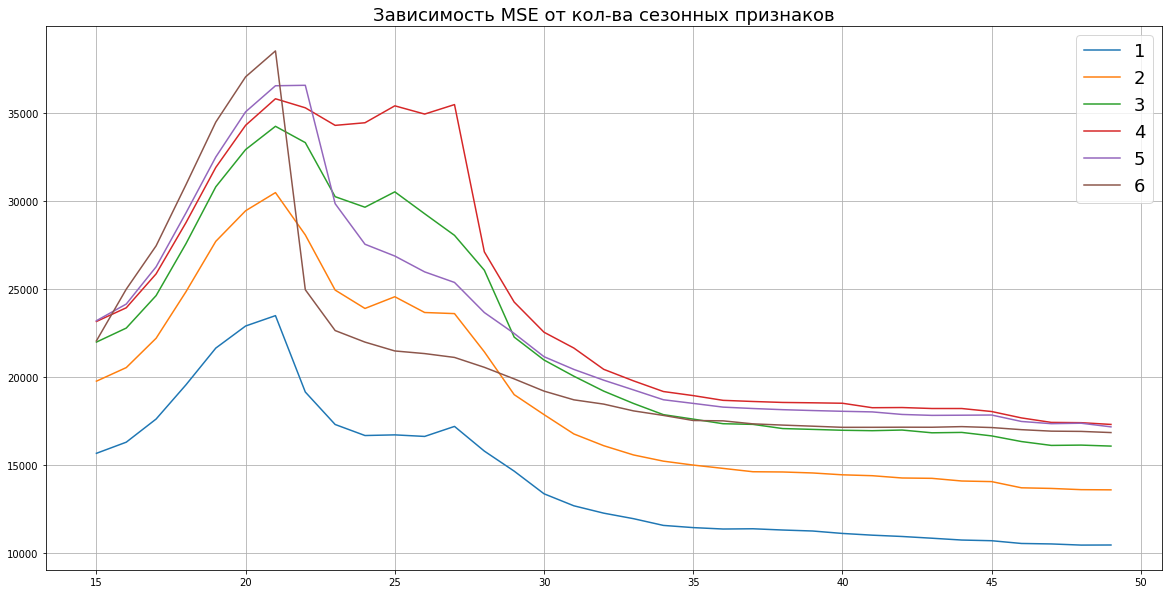

In [39]:
error_N = pd.DataFrame(mse_errors, index = range(15, 50), columns = range(1,7))
error_N.plot(figsize = (20, 10))
plt.title('Зависимость MSE от кол-ва сезонных признаков', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)

###### Оптимизируем коэф. K (кол-во поездок в момент времени (y.T-K))

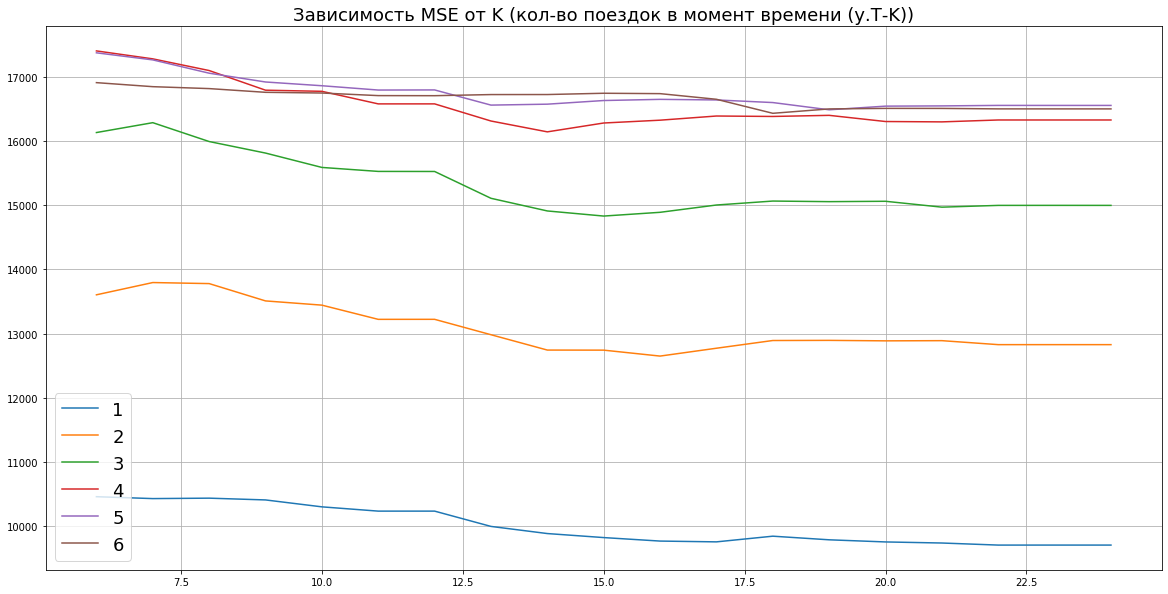

In [42]:
error_K = pd.DataFrame(mse_errors, index = range(6, 25), columns = range(1,7))
error_K.plot(figsize = (20, 10))
plt.title('Зависимость MSE от K (кол-во поездок в момент времени (y.T-K))', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)

###### Оптимизируем коэф. Kd (кол-во поездок в момент времени (y.T-24*Kd))

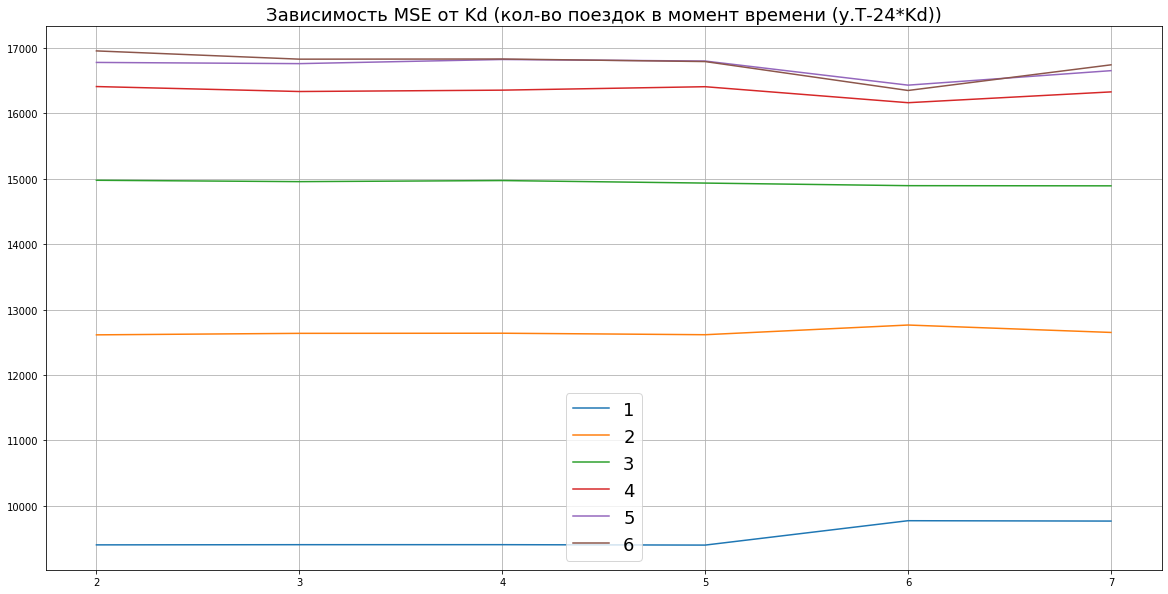

In [44]:
error_Kd = pd.DataFrame(mse_errors, index = range(2, 8), columns = range(1,7))
error_Kd.plot(figsize = (20, 10))
plt.title('Зависимость MSE от Kd (кол-во поездок в момент времени (y.T-24*Kd))', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)

2. Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке.

###### Формируем данные по регионам с января 2015 по июнь 2016

In [6]:
def merge_df(date_list):
    '''Объединение агрегированных данных'''
    df = pd.read_csv('data/df_regions/df_group_' + date_list[0] + '.csv', index_col=[0])
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    for n in date_list[1:]:
        df_merge = pd.read_csv('data/df_regions/df_group_' + n + '.csv', index_col=[0])
        df_merge.index = pd.to_datetime(df_merge.index, format='%Y-%m-%d %H:%M:%S')
        df = pd.concat([df, df_merge])
    return df

In [7]:
%%time
N_regions = pd.read_csv('data/df_regions/week4_region.csv', index_col=[0]).index
df = merge_df([
    '15-01','15-02','15-03','15-04','15-05','15-06','15-07','15-08','15-09','15-10','15-11','15-12',
                  '16-01','16-02', '16-03', '16-04', '16-05', '16-06'
]).iloc[:,list(N_regions-1)]

Wall time: 32.1 s


###### Добавляем дополнительные признаки и составляем матрицу признаков для обучения:

Во-первых:
* средняя длительность поездок
* среднее количество пассажиров
* среднее расстояние по счётчику
* средняя стоимость поездок

Во-вторых:
* праздничные дни

В-третьих:
* суммарное количество поездок за предшествующие полдня, сутки, неделю

In [8]:
def merge_features(date_list):
    '''Объединение агрегированных данных'''
    df = pd.read_csv('data/df_regions/week6_df_features_' + date_list[0] + '.csv', index_col=[0],  header=[0,1])
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

    for n in date_list[1:]:
        df_merge = pd.read_csv('data/df_regions/week6_df_features_' + n + '.csv', index_col=[0],  header=[0,1])
        df_merge.index = pd.to_datetime(df_merge.index, format='%Y-%m-%d %H:%M:%S')
        df = pd.concat([df, df_merge])
    return df

In [9]:
df_features = merge_features([
    '15-01','15-02','15-03','15-04','15-05','15-06','15-07','15-08','15-09','15-10','15-11','15-12',
                  '16-01','16-02', '16-03', '16-04', '16-05', '16-06'
])

In [10]:
def features(df, df_f):
    df_regions = pd.DataFrame(index=df.index)
    
    ## Признаки общие для всех регионов
    # календарные признаки
    df_regions[('for_all', 'X', 'year')] = df.index.year
    df_regions[('for_all', 'X', 'month')] = df.index.month
    df_regions[('for_all', 'X', 'day')] = df.index.day
    df_regions[('for_all', 'X', 'weekday')] = df.index.weekday
    df_regions[('for_all', 'X', 'hour')] = df.index.hour

    # праздничные дни
    NY_holidays = holidays.US(state='NY')
    NY_holidays_list = []
    for date, name in holidays.US(state='NY', years=[2015, 2016]).items():
        NY_holidays_list.append(np.datetime64(date))
    df_regions[('for_all', 'X', 'holiday')] = pd.to_datetime(df_regions.index.strftime('%Y-%m-%d')).isin(NY_holidays_list).astype(int)      
    
    N = 36
    row = np.arange(1, df.shape[0]+1)
    for i in range(1, N+1):
        # годовая сезонность
        df_regions[('for_all', 'X', 'y_c_'+str(i))] = np.cos(row*2*np.pi*i/8766)
        df_regions[('for_all', 'X', 'y_s_'+str(i))] = np.sin(row*2*np.pi*i/8766)
        # недельная сезонность
        df_regions[('for_all', 'X', 'w_c_'+str(i))] = np.cos(row*2*np.pi*i/168)
        df_regions[('for_all', 'X', 'w_s_'+str(i))] = np.sin(row*2*np.pi*i/168)
        # дневная сезонность
        df_regions[('for_all', 'X', 'd_c_'+str(i))] = np.cos(row*2*np.pi*i/24)
        df_regions[('for_all', 'X', 'd_s_'+str(i))] = np.sin(row*2*np.pi*i/24)

    ## Признаки индивидуальные для каждого региона
    for region in df.columns:
        
        # кол-во поездок в момент времени (y.T-K)
        K = 15
        for k in range(1, K+1):
            df_regions[(region, 'X', 'T-'+str(k))] = df[region].shift(k)
        
        # кол-во поездок в момент времени (y.T-24*Kd)
        Kd = 2
        for kd in range(1, Kd+1):
            df_regions[(region, 'X', 'T-24*'+str(kd))] = df[region].shift(24*kd)
        
        # суммарное количество поездок за предшествующие полдня, сутки, неделю
        sum_N = [12, 24, 168]
        for sum_n in sum_N:
            df_regions[(region, 'X', 'sum_'+str(sum_n))] = df[region].rolling(min_periods=1, window=sum_n).sum().shift(1)
    
        # дополнительные признаки (средняя длительность поездокб, среднее количество пассажиров, среднее расстояние по счётчику, средняя стоимость поездок)
        for features in df_f[(str(region))].columns:
            df_regions[(region, 'X', str(features))] = df_f[(str(region), str(features))]
    
        ## Добавляем кол-во поездок по регионам
        df_regions[(region, 'y', 'real')] = df[region]
        for t in range(1,7):
            df_regions[(region, 'y', str(t))] = df[region].shift(-t)
    
    df_regions.columns = pd.MultiIndex.from_tuples(df_regions.columns, names=['region', 'X and y', 'features'])
    
    return df_regions[168:]

In [11]:
%%time
X_y = features(df, df_features)
X_y.fillna(0, inplace = True)

Wall time: 50.3 s


In [13]:
def predict_model(df):
    regions = np.unique((df.columns.get_level_values(level='region')))[:-1]
    len_region = regions.shape[0]
    
    start_may = '2016-04-30 23:00:00'
    end_may = '2016-05-31 17:00:00'
    predict_may = pd.DataFrame(index=df[start_may:end_may].index)

    start_june = '2016-05-31 23:00:00'
    end_june = '2016-06-30 17:00:00'
    predict_june = pd.DataFrame(index=df[start_june:end_june].index)
    
    for region in regions:
        print('Расчет предсказания для региона - {}, осталось обработать регионов - {}'.format(region, len_region-1))
        len_region -= 1
        
        X = pd.merge(df[('for_all','X')], df[(region, 'X')], left_index=True, right_index=True)
        
        for t in range(1, 7):
            print('Расчет предсказания на {} ч вперед'.format(t))
            y = df[(region, 'y', str(t))]
            ## ПРЕДСКАЗАНИЕ НА МАЙ 2016
            # разделяем данные на обучение, тестовые и итоговые
            X_train, y_train = X[:predict_may.index[0] - timedelta(hours=1)], y[:predict_may.index[0] - timedelta(hours=1)]
            X_test_may = X[start_may:end_may]
            predict_may[(region, 'y', str(t))] = df[(region, 'y', str(t))][start_may:end_may]

            # построение модели с подбором гиперпараметров
            model = Ridge()
            param_grid = [{'alpha' : np.logspace(2, 3, 50)}]
            clf = GridSearchCV(model, param_grid, cv = 5)
            best_model = clf.fit(X_train, y_train)

            # сохраняем предсказания
            predict_may[(region, 'y_predict', str(t))] = best_model.predict(X_test_may).round()   
            predict_may[(region, 'error', str(t))] = (predict_may[(region, 'y_predict', str(t))] - predict_may[(region, 'y', str(t))]).abs()

            ## ПРЕДСКАЗАНИЕ НА ИЮНЬ 2016 
            # разделяем данные на обучение, тестовые и итоговые
            X_test_june = X[start_june:end_june]
            predict_june[(region, 'y', str(t))] = df[(region, 'y', str(t))][start_june:end_june]

            # сохраняем предсказания
            predict_june[(region, 'y_predict', str(t))] = best_model.predict(X_test_june).round()   
            predict_june[(region, 'error', str(t))] = (predict_june[(region, 'y_predict', str(t))] - predict_june[(region, 'y', str(t))]).abs()
    
    predict_may.columns = pd.MultiIndex.from_tuples(predict_may.columns, names=['region', 'y', 'delta'])
    predict_june.columns = pd.MultiIndex.from_tuples(predict_june.columns, names=['region', 'y', 'delta'])
    
    return predict_may, predict_june 

In [14]:
%%time
y_may, y_june = predict_model(X_y)

Расчет предсказания для региона - 1075, осталось обработать регионов - 101
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1076, осталось обработать регионов - 100
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1077, осталось обработать регионов - 99
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1125, осталось обработать регионов - 98
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1126, осталось обработать регионов - 97
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1127, осталось обработать регионов - 96
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1128, осталось обработать регионов - 95
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1129, осталось обработать регионов - 94
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1130, осталось обработать регионов - 93
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1131, осталось обработать регионов - 92
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1132, осталось обработать регионов - 91
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1172, осталось обработать регионов - 90
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1173, осталось обработать регионов - 89
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1174, осталось обработать регионов - 88
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1175, осталось обработать регионов - 87
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1176, осталось обработать регионов - 86
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1177, осталось обработать регионов - 85
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1178, осталось обработать регионов - 84
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1179, осталось обработать регионов - 83
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1180, осталось обработать регионов - 82
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1181, осталось обработать регионов - 81
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1182, осталось обработать регионов - 80
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1183, осталось обработать регионов - 79
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1184, осталось обработать регионов - 78
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1221, осталось обработать регионов - 77
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1222, осталось обработать регионов - 76
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1223, осталось обработать регионов - 75
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1224, осталось обработать регионов - 74
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1225, осталось обработать регионов - 73
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1227, осталось обработать регионов - 72
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1228, осталось обработать регионов - 71
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1229, осталось обработать регионов - 70
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1230, осталось обработать регионов - 69
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1231, осталось обработать регионов - 68
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1232, осталось обработать регионов - 67
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1233, осталось обработать регионов - 66
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1234, осталось обработать регионов - 65
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1235, осталось обработать регионов - 64
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1272, осталось обработать регионов - 63
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1273, осталось обработать регионов - 62
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1274, осталось обработать регионов - 61
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1278, осталось обработать регионов - 60
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1279, осталось обработать регионов - 59
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1280, осталось обработать регионов - 58
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1281, осталось обработать регионов - 57
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1282, осталось обработать регионов - 56
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1283, осталось обработать регионов - 55
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1284, осталось обработать регионов - 54
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1285, осталось обработать регионов - 53
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1286, осталось обработать регионов - 52
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1287, осталось обработать регионов - 51
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1326, осталось обработать регионов - 50
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1327, осталось обработать регионов - 49
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1331, осталось обработать регионов - 48
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1332, осталось обработать регионов - 47
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1333, осталось обработать регионов - 46
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1334, осталось обработать регионов - 45
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1335, осталось обработать регионов - 44
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1336, осталось обработать регионов - 43
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1337, осталось обработать регионов - 42
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1338, осталось обработать регионов - 41
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1339, осталось обработать регионов - 40
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1376, осталось обработать регионов - 39
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1377, осталось обработать регионов - 38
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1378, осталось обработать регионов - 37


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 1 ч вперед
Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1380, осталось обработать регионов - 36
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1382, осталось обработать регионов - 35
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1383, осталось обработать регионов - 34
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1384, осталось обработать регионов - 33
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1385, осталось обработать регионов - 32
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1386, осталось обработать регионов - 31
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1387, осталось обработать регионов - 30
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1388, осталось обработать регионов - 29
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1389, осталось обработать регионов - 28
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1390, осталось обработать регионов - 27
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1426, осталось обработать регионов - 26
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1431, осталось обработать регионов - 25
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1434, осталось обработать регионов - 24
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1435, осталось обработать регионов - 23
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1436, осталось обработать регионов - 22
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1437, осталось обработать регионов - 21
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1438, осталось обработать регионов - 20
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1439, осталось обработать регионов - 19
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1441, осталось обработать регионов - 18
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1442, осталось обработать регионов - 17
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1480, осталось обработать регионов - 16
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1482, осталось обработать регионов - 15
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1483, осталось обработать регионов - 14
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1530, осталось обработать регионов - 13
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1532, осталось обработать регионов - 12
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1533, осталось обработать регионов - 11
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1580, осталось обработать регионов - 10
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1630, осталось обработать регионов - 9
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1684, осталось обработать регионов - 8
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1733, осталось обработать регионов - 7
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1734, осталось обработать регионов - 6
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 1783, осталось обработать регионов - 5
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 2068, осталось обработать регионов - 4
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 2069, осталось обработать регионов - 3
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 2118, осталось обработать регионов - 2
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 2119, осталось обработать регионов - 1
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Расчет предсказания для региона - 2168, осталось обработать регионов - 0
Расчет предсказания на 1 ч вперед


C:\Program Files\Conda_3\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


Расчет предсказания на 2 ч вперед
Расчет предсказания на 3 ч вперед
Расчет предсказания на 4 ч вперед
Расчет предсказания на 5 ч вперед
Расчет предсказания на 6 ч вперед
Wall time: 7h 36min 9s


In [21]:
y_june.to_csv('data/df_regions/week6_june.csv')

3. Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Убедитесь, что среднее качество прогнозов увеличилось.

In [15]:
%%time
print('Ошибка качества прогнозов моделей за май составляет ', error(y_may))

Ошибка качества прогнозов моделей за май составляет  20.964395004731706
Wall time: 39 ms


4. Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

In [16]:
def kaggle(df):
    df_predict = df.xs('y_predict', level='y', axis=1)
    list_date = []
    list_predict = []
    for date in df_predict.index:
        for region_delta in df_predict.columns:
            list_date.append(str(region_delta[0])+'_'+str(date)[:10]+'_'+str(date.hour)+'_'+str(region_delta[1]))
            list_predict.append(df_predict[(region_delta)][date])
    return pd.DataFrame(np.array((list_date, list_predict)).T, columns=['id', 'y'])

In [18]:
%%time
print('Ошибка качества прогнозов моделей за июнь составляет ', error(y_june))
kaggle_df = kaggle(y_june)
kaggle_df.to_csv('data/df_regions/result_june_week6.csv', index=False)

Ошибка качества прогнозов моделей за июнь составляет  17.5737556561086
Wall time: 58.4 s


###### Вывод: Ошибка качества прогноза при добавлении дополнительных признаков уменьшилась по сравнению с предыдущей неделей (с 20.996 до 17.574)

5. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

[**ссылка**](https://www.kaggle.com/c/yellowtaxi/submissions?sortBy=date&group=successful&page=1&pageSize=100), если не сработает вот скриншот

In [19]:
from IPython.display import Image # Библиотека для отображения картинок

display(Image(url='data/df_regions/kaggle_week6.png', width = 900))

6. Загрузите ноутбук в форму.

---